# News Categorizer

Predicting news article categories by headline text.

Compares three models: Naive Bayes, SGD, and neural network.

The dataset is from https://www.kaggle.com/uciml/news-aggregator-dataset.

It contains headlines, URLs, and categories for 422,937 news stories
collected by a web aggregator between March 10th, 2014 and August 10th, 2014.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import unicodedata
import string
import os
import csv
import re

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.utils import shuffle

import sklearn.metrics as skm

## Retrieve raw data

Read dataset as a CSV from local file.

In [143]:
news_df = pd.read_csv(os.path.join('news-data', 'uci-news-aggregator.csv'), header=0, index_col=0, dtype=str)
print('Read .csv file from local copy of dataset.')
print(news_df.shape)
news_df.head()

Read .csv file from local copy of dataset.
(422419, 7)


,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,"Fed official says weak data caused by weather,...",http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,Fed's Charles Plosser sees high bar for change...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,US open: Stocks fall after Fed official hints ...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,"Fed risks falling 'behind the curve', Charles ...",http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,Fed's Plosser: Nasty Weather Has Curbed Job Gr...,http://www.moneynews.com/Economy/federal-reser...,Moneynews,b,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


## Pre-preprocessing

Preprocessing transformations that can happen before the train/test split are those that are not dependent on the values contained in the dataset itself.

Such steps are:

* Checking for null values
* Renaming columns
* Standardising case
* Removing punctuation

There are 2 null values in `PUBLISHER`,
but that field is neither a relevant feature nor the label to be predicted.

In [125]:
# Check for null values
news_df.isnull().sum()

TITLE        0
URL          0
PUBLISHER    2
CATEGORY     0
STORY        0
HOSTNAME     0
TIMESTAMP    0
dtype: int64

In [126]:
# Make labels more intuitive and human-readable
CATEGORY_DICT = {
    'b':'business',
    'e':'entertainment',
    'm':'health',
    't':'science/technology'
}

news_df['CATEGORY'] = news_df['CATEGORY'].map(category_dict)

In [127]:
def remove_punctuation(s1):
    """
    Returns s1 unicode-normalised without punctuation.
    """
    s1 = s1.translate(str.maketrans('', '', string.punctuation))

    return unicodedata.normalize("NFKD", s1)

The relevant feature is the headline text (in `TITLE`), and the label is the news category (in `CATEGORY`).

In [128]:
# Make all the headlines lowercase and remove punctuation
news_df['TITLE'] = news_df['TITLE'].str.lower()
news_df['TITLE'] = news_df['TITLE'].apply(remove_punctuation)

# Designate features and labels
features = news_df[['TITLE']]
labels = news_df[['CATEGORY']]

news_df.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
1,fed official says weak data caused by weather ...,http://www.latimes.com/business/money/la-fi-mo...,Los Angeles Times,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.latimes.com,1394470370698
2,feds charles plosser sees high bar for change ...,http://www.livemint.com/Politics/H2EvwJSK2VE6O...,Livemint,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.livemint.com,1394470371207
3,us open stocks fall after fed official hints a...,http://www.ifamagazine.com/news/us-open-stocks...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371550
4,fed risks falling behind the curve charles plo...,http://www.ifamagazine.com/news/fed-risks-fall...,IFA Magazine,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.ifamagazine.com,1394470371793
5,feds plosser nasty weather has curbed job growth,http://www.moneynews.com/Economy/federal-reser...,Moneynews,business,ddUyU0VZz0BRneMioxUPQVP6sIxvM,www.moneynews.com,1394470372027


# Statistical machine learning approach, naive Bayes and SGD

We use `sklearn`'s implementations of both models.

In [129]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((337935, 1), (84484, 1), (337935, 1), (84484, 1))

### Preprocessing

In each instance, we avoid data leakage by
"fitting on train and transforming both train and test".

This ensures that information contained in the test set
is not factored in by the model at training time (avoids over-optimistic results).


The preprocessing steps are shared between naive Bayes and SGD:

* Convert text (the single feature) into count vectors
* Encode the categories (the label)

In [130]:
# Turn text into integer count vectors
vectorizer = CountVectorizer()
vectorizer.fit(x_train['TITLE'])

x_train = vectorizer.transform(x_train['TITLE'])
x_test = vectorizer.transform(x_test['TITLE'])

# Turn categories into integers
# 0: business, 1: entertainment, 2: health, 3: science/technology
encoder = LabelEncoder()
encoder.fit(y_train['CATEGORY'])

y_train = encoder.transform(y_train['CATEGORY'])
y_test = encoder.transform(y_test['CATEGORY'])

### Training and evaluating the models

Both models' accuracies are above 90%, with default parameters.

SGD outperforms the Naive Bayes (~93.7% compared to ~92.6%), but takes slightly longer to train.

In [131]:
# Naive Bayes model
nb = MultinomialNB()
nb.fit(x_train, y_train)

score = nb.score(x_test, y_test)
print(f'Multinomial Naive Bayes accuracy:\n\n{score}')

Multinomial Naive Bayes accuracy:

0.9266014866720326


In [132]:
# Stochastic gradient descent classifier
sgd = SGDClassifier(early_stopping=True)
sgd.fit(x_train, y_train)

score = sgd.score(x_test, y_test)
print(f'SGD classsifier accuracy:\n\n{score}')

SGD classsifier accuracy:

0.9375976516263435


#### Some other classifier models

These models are relatively slow to train, and underperformed in tests.

In [133]:
# from sklearn.svm import LinearSVC

# svc = LinearSVC()
# svc.fit(x_train, y_train)
# svc.score(x_test, y_test)

In [134]:
# from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier()
# forest = forest.fit(x_train, y_train)
# forest.score(x_test, y_test)

### Visualizing the results

We use `seaborn`'s heatmap to visualise the confusion matrices.

In [137]:
def confusion_mat(model_name, confusion_matrix, cmap='YlOrBr'):
    '''
    Displays the given confusion matrix for the given model name.
    '''

    cm = pd.DataFrame(confusion_matrix)
    sns.set(font_scale = 1.5)
    plt.figure(figsize = (8,8))
    
    # x and y labels are based on the global CATEGORY_DICT
    sns.heatmap(cm, cmap = cmap,linewidths = 1, annot = True,square = True, fmt='d', cbar = False,
                xticklabels = CATEGORY_DICT.values(),
                yticklabels = CATEGORY_DICT.values())
    plt.xticks(rotation = 0)
    plt.yticks(rotation = 0)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted Classes', rotation=0)
    plt.ylabel('Actual Classes', rotation=0)

#### Visualize Naive Bayes

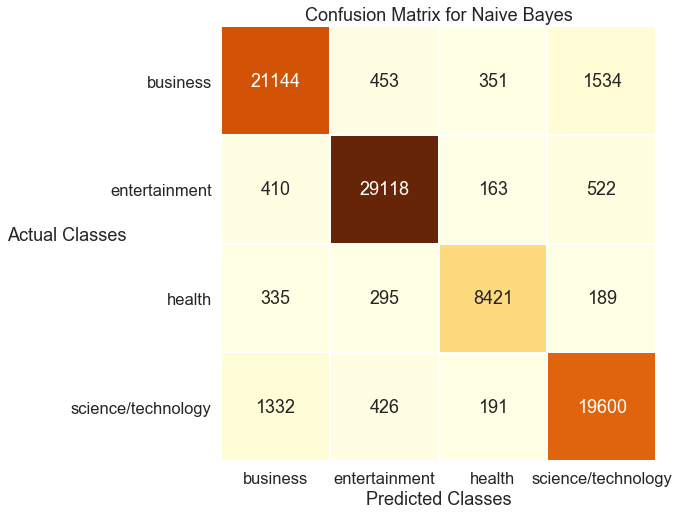

In [138]:
# Visualise Naive Bayes
y_pred = nb.predict(x_test)
matrix = skm.confusion_matrix(y_test, y_pred)
confusion_mat('Naive Bayes', matrix)

#### Visualize SGD

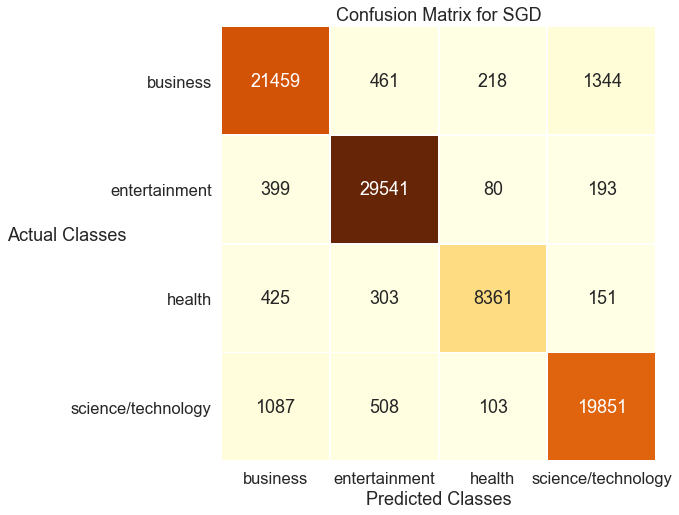

In [144]:
y_pred = sgd.predict(x_test)
matrix = skm.confusion_matrix(y_test, y_pred)
confusion_mat('SGD', matrix)

## Testing the models on data not in the dataset

In [145]:
def predict_categories(model, titles):
    '''
    Use the given model to predict categories for the given news headline titles. 
    '''
    titles = pd.Series(titles)
    
    # mirror preprocessing transformations before feeding as input to the model
    titles = titles.str.lower()
    titles = titles.apply(remove_punctuation)
    
    text = vectorizer.transform(titles)

    categories = model.predict(text)
    
    return encoder.inverse_transform(categories)

Now we test the models on some recent (June 2020) article headlines from the New York Times, Reuters, E!, and other websites. Some non-obvious headlines (e.g. 'Watch This Black Hole Blow Bubbles') are deliberately chosen.

In [150]:
titles = [
    'The Sea’s Weirdest Creatures, Now in ‘Staggering’ Detail',
    'Watch This Black Hole Blow Bubbles',
    'Falling Jobless Rate Could Imperil Aid Underpinning the Recovery',
    'OPEC and Russia Are Likely to Extend Oil Production Cuts',
    'Doctors Heavily Overprescribed Antibiotics Early in the Pandemic',
    '15 Years Since Tom Cruise Infamously Jumped on Oprah\'s Couch',
    'YouTube is hosting a star-studded tribute to the class of 2020 this weekend',
    'Malaysia reports 37 new coronavirus cases, one new death',
    'Protests in Australia, Japan embrace \'Black Lives Matter\' movement',
    'Tesla Model Y attacks the race track on Autopilot'
]
test_df = pd.DataFrame(titles, columns=['title'])

In [149]:
# Naive Bayes predictions

test_df['predicted_category'] = predict_categories(nb, titles)
test_df.sort_values(by='predicted_category')

,title,predicted_category
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
8,"Protests in Australia, Japan embrace 'Black Li...",business
1,Watch This Black Hole Blow Bubbles,entertainment
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
6,YouTube is hosting a star-studded tribute to t...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
7,"Malaysia reports 37 new coronavirus cases, one...",health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
9,Tesla Model Y attacks the race track on Autopilot,science/technology


In [151]:
# SGD predictions

test_df['predicted_category'] = predict_categories(sgd, titles)
test_df.sort_values(by='predicted_category')

,title,predicted_category
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
8,"Protests in Australia, Japan embrace 'Black Li...",business
1,Watch This Black Hole Blow Bubbles,entertainment
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
6,YouTube is hosting a star-studded tribute to t...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
7,"Malaysia reports 37 new coronavirus cases, one...",health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
9,Tesla Model Y attacks the race track on Autopilot,science/technology


We see that the predictions of the two models are similar and mostly accurate,
and that **it is able to classify 2020 topics, despite being trained on 2014 news headlines.**

### Custom tests

In [156]:
custom_title = input("(Naive Bayes) Type in a news headline:\n\n")
print(
    f'\npredicted category: '
    f'{predict_categories(nb, [custom_title,])[0]}.'
)

(Naive Bayes) Type in a news headline:



predicted category: entertainment.


# Neural Network Approach with Keras

In [58]:
# split into train and test sets
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((337935, 1), (84484, 1), (337935, 1), (84484, 1))

In [59]:
headline_lengths = [len(x) for x in news_df['TITLE'].values]
print(f'average length of headline text: {np.mean(headline_lengths):.3f} characters')

average length of headline text: 54.908 characters


In [60]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

# from keras.utils.np_utils import to_categorical
# from keras.callbacks import EarlyStopping

# turn titles into lists of tokens,
# each token is represented by a number,
# which is its index in the dictionary of 10000 most common unique tokens
# contained in the text it was fitted on, i.e. all the headlines in the dataset

n_most_common_words = 10000
tokenizer = Tokenizer(num_words=n_most_common_words, filters=string.punctuation, lower=True)
tokenizer.fit_on_texts(x_train['TITLE'].values)

x_train = tokenizer.texts_to_sequences(x_train['TITLE'].values)
x_test = tokenizer.texts_to_sequences(x_test['TITLE'].values)

# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

#X = pad_sequences(sequences, maxlen=max_len)

Using TensorFlow backend.


In [61]:
# set max title length to be used as input to be 200
# pad and truncate as necessary

max_title_length = 200

x_train = pad_sequences(x_train, maxlen=max_title_length)
x_test = pad_sequences(x_test, maxlen=max_title_length)

#features.shape

In [62]:
onehot = OneHotEncoder()
onehot.fit(y_train)

y_train = onehot.transform(y_train)
y_test = onehot.transform(y_test)

#labels = encoder.transform(news_df['CATEGORY'])

In [63]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers.embeddings import Embedding
from keras.layers import Flatten

embedding_vector_length = 32
model = Sequential()
model.add(Embedding(n_most_common_words, embedding_vector_length, input_length=max_title_length))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           320000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                102416    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
Total params: 422,756
Trainable params: 422,756
Non-trainable params: 0
_________________________________________________________________
None


In [64]:
hist = model.fit(x_train, y_train.todense(),
                 validation_data=(x_test, y_test.todense()),
                 epochs=4,
                 batch_size=128)

C:\Users\Jonathan\miniconda3\envs\ml_env\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 337935 samples, validate on 84484 samples
Epoch 1/5
337935/337935 [==============================] - 24s 72us/step - loss: 0.1413 - accuracy: 0.9439 - val_loss: 0.0870 - val_accuracy: 0.9683
Epoch 2/5
337935/337935 [==============================] - 24s 71us/step - loss: 0.0760 - accuracy: 0.9720 - val_loss: 0.0827 - val_accuracy: 0.9695
Epoch 3/5
337935/337935 [==============================] - 24s 70us/step - loss: 0.0649 - accuracy: 0.9761 - val_loss: 0.0842 - val_accuracy: 0.9686
Epoch 4/5
337935/337935 [==============================] - 25s 75us/step - loss: 0.0545 - accuracy: 0.9803 - val_loss: 0.0899 - val_accuracy: 0.9674
Epoch 5/5
337935/337935 [==============================] - 24s 71us/step - loss: 0.0454 - accuracy: 0.9837 - val_loss: 0.0980 - val_accuracy: 0.9655


[]

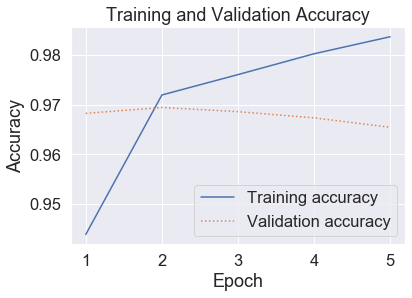

In [70]:
#0.9645
# > 0.9637
# sig0.9669
%matplotlib inline

acc = hist.history['accuracy']
val = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training accuracy')
plt.plot(epochs, val, ':', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

[]

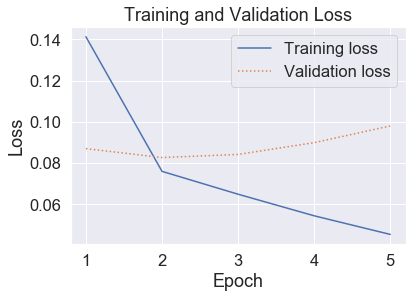

In [72]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, ':', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.plot()

In [79]:
score = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.4f}\n  Accuracy: {:0.4f}'.format(score[0],score[1]))

84484/84484 [==============================] - 3s 32us/step
Test set
  Loss: 0.0980
  Accuracy: 0.9655


In [80]:
def predict_categories_nn(model, titles):
    
    sequences = tokenizer.texts_to_sequences(titles)
    text = pad_sequences(sequences, maxlen=max_title_length)

    categories = model.predict_classes(text)
    
    return encoder.inverse_transform(categories)

In [81]:
test_df['predicted_category'] = predict_categories_nn(model, titles)
test_df.sort_values(by='predicted_category')

,title,predicted_category
2,Falling Jobless Rate Could Imperil Aid Underpi...,business
3,OPEC and Russia Are Likely to Extend Oil Produ...,business
5,15 Years Since Tom Cruise Infamously Jumped on...,entertainment
6,YouTube is hosting a star-studded tribute to t...,entertainment
4,Doctors Heavily Overprescribed Antibiotics Ear...,health
0,"The Sea’s Weirdest Creatures, Now in ‘Staggeri...",science/technology
1,Watch This Black Hole Blow Bubbles,science/technology
